In [1]:
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
import random
import os
from tqdm.notebook import tqdm
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torch import nn
import torch.optim as optim
import optuna
import torch.nn as nn


## DATASET

In [206]:
data_dir = 'dataset'
train_dataset = torchvision.datasets.FashionMNIST(data_dir, train=True, download=True)
test_dataset  = torchvision.datasets.FashionMNIST(data_dir, train=False, download=True)

In [209]:
train_transform = transforms.Compose([
    transforms.ToTensor(),
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
])
train_dataset.transform = train_transform
test_dataset.transform = test_transform

### Train dataloader
train_dataloader = DataLoader(train_dataset, batch_size=200, shuffle=True, num_workers=3)
### Test dataloader
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataloader), shuffle=False, num_workers=3)



## ENCODER

In [210]:
class Encoder(nn.Module):
    
    def __init__(self, params):
        super().__init__()
        
        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            # First convolutional layer
            nn.Conv2d(in_channels=1, out_channels=params['Ch1'], kernel_size=3, 
                      stride=2, padding=1), 
            nn.ReLU(True),
            # Second convolutional layer
            nn.Conv2d(in_channels=params['Ch1'], out_channels=params['Ch2'], kernel_size=3, 
                      stride=2, padding=1),
            nn.ReLU(True),
            # Third convolutional layer
            nn.Conv2d(in_channels=params['Ch2'], out_channels=params['Ch3'], kernel_size=3, 
                      stride=2, padding=0),
            nn.ReLU(True)
        )
        
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)

        ### Linear section
        self.encoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(in_features=9*params['Ch3'], out_features=params['L1']),
            nn.ReLU(True),
            # Second linear layer
            nn.Linear(in_features=params['L1'], out_features=params['LS'])
        )
        
    def forward(self, x):
        # Apply convolutions
        x = self.encoder_cnn(x)
        # Flatten
        x = self.flatten(x)
        # # Apply linear layers
        x = self.encoder_lin(x)
        return x

In [211]:
# TODO: fill the holes with the number from the above figure.

class Decoder(nn.Module):
    
    def __init__(self, params):
        super().__init__()

        ### Linear section
        self.decoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(in_features=params['LS'], out_features=params['L1']),
            nn.ReLU(True),
            # Second linear layer
            nn.Linear(in_features=params['L1'], out_features=9*params['Ch3']),
            nn.ReLU(True)
        )

        ### Unflatten
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(params['Ch3'], 3, 3))

        ### Convolutional section
        self.decoder_conv = nn.Sequential(
            # First transposed convolution
            nn.ConvTranspose2d(in_channels=params['Ch3'], out_channels=params['Ch2'], kernel_size=3, 
                               stride=2, output_padding=0),
            nn.ReLU(True),
            # Second transposed convolution
            nn.ConvTranspose2d(in_channels=params['Ch2'], out_channels=params['Ch1'], kernel_size=3, 
                               stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            # Third transposed convolution
            nn.ConvTranspose2d(in_channels=params['Ch1'], out_channels=1, kernel_size=3, 
                               stride=2, padding=1, output_padding=1)
        )
        
    def forward(self, x):
        # Apply linear layers
        x = self.decoder_lin(x)
        # Unflatten
        x = self.unflatten(x)
        # Apply transposed convolutions
        x = self.decoder_conv(x)
        # Apply a sigmoid to force the output to be between 0 and 1 (valid pixel values)
        x = torch.sigmoid(x)
        return x

## TRAINING

In [212]:
### Training function
def train_epoch(encoder, decoder, dataloader, loss_fn, optimizer):
    # Set train mode for both the encoder and the decoder
    encoder.train()
    decoder.train()
    out = []
    for image_batch, _ in dataloader:
        # Encode data
        encoded_data = encoder(image_batch)
        # Decode data
        decoded_data = decoder(encoded_data)
        # Evaluate loss
        loss = loss_fn(decoded_data, image_batch)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        out.append(loss.detach())
    return np.mean(out)
        
        
### Testing function
def test_epoch(encoder, decoder, dataloader, loss_fn):
    # Set evaluation mode for encoder and decoder
    encoder.eval()
    decoder.eval()
    with torch.no_grad():
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        for image_batch, _ in dataloader:
            # Encode data
            encoded_data = encoder(image_batch)
            # Decode data
            decoded_data = decoder(encoded_data)
            # Append the network output and the original image to the lists
            conc_out.append(decoded_data)
            conc_label.append(image_batch)
        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data

In [213]:
def train(num_epochs, encoder, decoder, train_dataloader, test_dataloader, loss_fn, optimizer):
    ### Training cycle
    Val_loss = []
    Train_loss = []
    pbar = tqdm(range(num_epochs),desc = 'Val loss: ',leave=False)
    for epoch in pbar:
        ### Training (use the training function)
        train_loss = train_epoch(
            encoder=encoder, 
            decoder=decoder, 
            dataloader=train_dataloader, 
            loss_fn=loss_fn, 
            optimizer=optimizer)
        ### Validation  (use the testing function)
        val_loss = test_epoch(
            encoder=encoder, 
            decoder=decoder, 
            dataloader=test_dataloader, 
            loss_fn=loss_fn)
        Val_loss.append(val_loss)
        Train_loss.append(train_loss)
        pbar.set_description('Val loss: ' + str(val_loss.item())[:4])
        
    return Train_loss,Val_loss

In [214]:
def Kfold(i,s):
    ind = i.copy()
    np.random.shuffle(ind)
    fold = np.array_split(ind,s)
    K = []
    k = [i for i in range(s)]
    for i in k:
        app = k.copy()
        app.pop(i)
        app2 = np.concatenate([fold[j] for j in app])
        K.append([app2,fold[i]])
    return K

def KTrain(params, epochs, train_df, k):
    val_loss = []
    for fold in tqdm(Kfold(np.arange(len(train_df)),k) ,desc= "Fold", leave = False):
        
        train_data = torch.utils.data.Subset(train_df, fold[0])
        val_data = torch.utils.data.Subset(train_df, fold[1])

        batch_size = 250
        train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=3)
        val_dataloader = DataLoader(val_data, batch_size=len(val_data), shuffle=False)
        
        #------------------- M O D E L ------------------------
        
        enc = Encoder(params)
        dec = Decoder(params)

        params_to_optimize = [
            {'params': enc.parameters()},
            {'params': dec.parameters()}
        ]

        optimizer = getattr(optim, params['optimizer'])(params_to_optimize, 
                            lr= params['lr'], weight_decay = params["weight"])
        loss_fn = torch.nn.MSELoss()
        
        
        #------------------- T R A I N ------------------------
        
        tl, vl = train(epochs, enc, dec, train_dataloader, test_dataloader, loss_fn, optimizer)
        val_loss.append(vl[-1])
        
    return val_loss

In [9]:
torch.manual_seed(10)

params ={
    'Ch1': 8,
    'Ch2': 16,
    'Ch3': 32,
    'L1': 64,
    'LS': 4,
    'lr': 1e-3,
    'weight': 1e-5,
    'optimizer': 'Adam'
}

loss_fn = torch.nn.MSELoss()
enc = Encoder(params)
dec = Decoder(params)

params_to_optimize = [
    {'params': enc.parameters()},
    {'params': dec.parameters()}
]

optimizer = getattr(optim, params['optimizer'])(params_to_optimize, 
                            lr= params['lr'], weight_decay = params["weight"])

epochs = 5
train_loss, val_loss = train(epochs, enc, dec, train_dataloader, test_dataloader, loss_fn, optimizer)


Val loss:   0%|          | 0/5 [00:00<?, ?it/s]

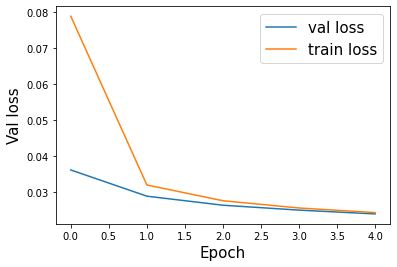

In [10]:
plt.plot(val_loss, label = "val loss")
plt.plot(train_loss, label = "train loss")
plt.xlabel('Epoch',fontsize=15)
plt.ylabel('Val loss',fontsize=15)

plt.legend(fontsize=15)

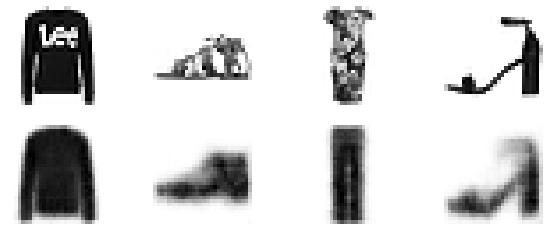

In [11]:
fig, axs = plt.subplots(2, 4, figsize=(10,4))

for i,j in enumerate([1,11,100,1200]):
    x = test_dataset[j][0]
    x = x.reshape([1,1,28,28])
    y = dec(enc(x)).detach()
    axs[0,i].imshow(-x[0][0], cmap='gist_gray')
    axs[1,i].imshow(-y[0][0], cmap='gist_gray')
    
for a in axs.flatten():
    a.set_xticks([])
    a.set_yticks([])
    a.axis('off')
    

## HYPERPARAMETER OPTIMIZATION

In [15]:
torch.manual_seed(2098)  

def objective(trial):
    # Parameters
    params = {
    'Ch1' : trial.suggest_int('Ch1', 8,10),
    'Ch2' : trial.suggest_int('Ch2', 15,20),
    'Ch3' : trial.suggest_int('Ch3', 25,35),
    'L1' : trial.suggest_int('L1', 60,80),
    'LS' : trial.suggest_categorical('LS', [2,4,8]),
    'lr'  : trial.suggest_loguniform('lr', 1e-4, 1e-2),
    'weight'  : trial.suggest_loguniform('weight', 1e-5, 1e-3),
    'optimizer': trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"])
    }
    epochs = 5
    val_loss = KTrain(params, epochs, train_dataset, 3)
    
    return np.mean(val_loss)

pruner: optuna.pruners.BasePruner = optuna.pruners.NopPruner()

study = optuna.create_study(study_name="myfirstoptimizationstudy", direction="minimize", pruner=pruner)
study.optimize(objective, n_trials=10)


# PRINT
print("Number of finished trials: {}".format(len(study.trials)))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2022-07-06 11:05:41,146] A new study created in memory with name: myfirstoptimizationstudy


Fold:   0%|          | 0/3 [00:00<?, ?it/s]

Val loss:   0%|          | 0/5 [00:00<?, ?it/s]

Val loss:   0%|          | 0/5 [00:00<?, ?it/s]

Val loss:   0%|          | 0/5 [00:00<?, ?it/s]

[I 2022-07-06 11:08:19,912] Trial 0 finished with value: 0.15767256915569305 and parameters: {'Ch1': 10, 'Ch2': 15, 'Ch3': 32, 'L1': 68, 'LS': 8, 'lr': 0.0009043392637625101, 'weight': 1.392991196882638e-05, 'optimizer': 'SGD'}. Best is trial 0 with value: 0.15767256915569305.


Fold:   0%|          | 0/3 [00:00<?, ?it/s]

Val loss:   0%|          | 0/5 [00:00<?, ?it/s]

Val loss:   0%|          | 0/5 [00:00<?, ?it/s]

Val loss:   0%|          | 0/5 [00:00<?, ?it/s]

[I 2022-07-06 11:12:31,840] Trial 1 finished with value: 0.08709955215454102 and parameters: {'Ch1': 8, 'Ch2': 15, 'Ch3': 33, 'L1': 76, 'LS': 8, 'lr': 0.009554048294344485, 'weight': 3.166373344581797e-05, 'optimizer': 'RMSprop'}. Best is trial 1 with value: 0.08709955215454102.


Fold:   0%|          | 0/3 [00:00<?, ?it/s]

Val loss:   0%|          | 0/5 [00:00<?, ?it/s]

Val loss:   0%|          | 0/5 [00:00<?, ?it/s]

Val loss:   0%|          | 0/5 [00:00<?, ?it/s]

[I 2022-07-06 11:15:26,750] Trial 2 finished with value: 0.03557237610220909 and parameters: {'Ch1': 9, 'Ch2': 17, 'Ch3': 28, 'L1': 73, 'LS': 8, 'lr': 0.00021484131170425733, 'weight': 9.918259180770279e-05, 'optimizer': 'Adam'}. Best is trial 2 with value: 0.03557237610220909.


Fold:   0%|          | 0/3 [00:00<?, ?it/s]

Val loss:   0%|          | 0/5 [00:00<?, ?it/s]

Val loss:   0%|          | 0/5 [00:00<?, ?it/s]

Val loss:   0%|          | 0/5 [00:00<?, ?it/s]

[I 2022-07-06 11:18:04,937] Trial 3 finished with value: 0.16387403011322021 and parameters: {'Ch1': 8, 'Ch2': 16, 'Ch3': 32, 'L1': 66, 'LS': 8, 'lr': 0.00014978733916730743, 'weight': 0.0007600605509969342, 'optimizer': 'SGD'}. Best is trial 2 with value: 0.03557237610220909.


Fold:   0%|          | 0/3 [00:00<?, ?it/s]

Val loss:   0%|          | 0/5 [00:00<?, ?it/s]

Val loss:   0%|          | 0/5 [00:00<?, ?it/s]

Val loss:   0%|          | 0/5 [00:00<?, ?it/s]

[I 2022-07-06 11:20:46,379] Trial 4 finished with value: 0.13606685400009155 and parameters: {'Ch1': 8, 'Ch2': 18, 'Ch3': 30, 'L1': 70, 'LS': 8, 'lr': 0.008008412459741586, 'weight': 5.529318588612352e-05, 'optimizer': 'SGD'}. Best is trial 2 with value: 0.03557237610220909.


Fold:   0%|          | 0/3 [00:00<?, ?it/s]

Val loss:   0%|          | 0/5 [00:00<?, ?it/s]

Val loss:   0%|          | 0/5 [00:00<?, ?it/s]

Val loss:   0%|          | 0/5 [00:00<?, ?it/s]

[I 2022-07-06 11:24:38,270] Trial 5 finished with value: 0.08723604679107666 and parameters: {'Ch1': 8, 'Ch2': 15, 'Ch3': 31, 'L1': 76, 'LS': 8, 'lr': 0.008371290353231338, 'weight': 5.51784322112107e-05, 'optimizer': 'RMSprop'}. Best is trial 2 with value: 0.03557237610220909.


Fold:   0%|          | 0/3 [00:00<?, ?it/s]

Val loss:   0%|          | 0/5 [00:00<?, ?it/s]

Val loss:   0%|          | 0/5 [00:00<?, ?it/s]

Val loss:   0%|          | 0/5 [00:00<?, ?it/s]

[I 2022-07-06 11:27:23,290] Trial 6 finished with value: 0.024810200557112694 and parameters: {'Ch1': 8, 'Ch2': 17, 'Ch3': 32, 'L1': 69, 'LS': 4, 'lr': 0.003082367898008725, 'weight': 0.00012445297763786668, 'optimizer': 'Adam'}. Best is trial 6 with value: 0.024810200557112694.


Fold:   0%|          | 0/3 [00:00<?, ?it/s]

Val loss:   0%|          | 0/5 [00:00<?, ?it/s]

Val loss:   0%|          | 0/5 [00:00<?, ?it/s]

Val loss:   0%|          | 0/5 [00:00<?, ?it/s]

[I 2022-07-06 11:30:06,818] Trial 7 finished with value: 0.13276822865009308 and parameters: {'Ch1': 8, 'Ch2': 20, 'Ch3': 25, 'L1': 66, 'LS': 4, 'lr': 0.008169135432989846, 'weight': 3.2444998733858415e-05, 'optimizer': 'SGD'}. Best is trial 6 with value: 0.024810200557112694.


Fold:   0%|          | 0/3 [00:00<?, ?it/s]

Val loss:   0%|          | 0/5 [00:00<?, ?it/s]

Val loss:   0%|          | 0/5 [00:00<?, ?it/s]

Val loss:   0%|          | 0/5 [00:00<?, ?it/s]

[I 2022-07-06 11:33:16,891] Trial 8 finished with value: 0.03286011144518852 and parameters: {'Ch1': 9, 'Ch2': 19, 'Ch3': 32, 'L1': 63, 'LS': 2, 'lr': 0.0017073380634562538, 'weight': 2.4981092274077553e-05, 'optimizer': 'Adam'}. Best is trial 6 with value: 0.024810200557112694.


Fold:   0%|          | 0/3 [00:00<?, ?it/s]

Val loss:   0%|          | 0/5 [00:00<?, ?it/s]

Val loss:   0%|          | 0/5 [00:00<?, ?it/s]

Val loss:   0%|          | 0/5 [00:00<?, ?it/s]

[I 2022-07-06 11:36:10,148] Trial 9 finished with value: 0.1664351373910904 and parameters: {'Ch1': 9, 'Ch2': 18, 'Ch3': 26, 'L1': 78, 'LS': 2, 'lr': 0.0006909089894774951, 'weight': 7.980992329638395e-05, 'optimizer': 'SGD'}. Best is trial 6 with value: 0.024810200557112694.


Number of finished trials: 10
Best trial:
  Value: 0.024810200557112694
  Params: 
    Ch1: 8
    Ch2: 17
    Ch3: 32
    L1: 69
    LS: 4
    lr: 0.003082367898008725
    weight: 0.00012445297763786668
    optimizer: Adam


In [17]:
print(trial.params)

{'Ch1': 8, 'Ch2': 17, 'Ch3': 32, 'L1': 69, 'LS': 4, 'lr': 0.003082367898008725, 'weight': 0.00012445297763786668, 'optimizer': 'Adam'}


## BEST MODEL

In [215]:
torch.manual_seed(20)

params = trial.params

loss_fn = torch.nn.MSELoss()
enc = Encoder(params)
dec = Decoder(params)

params_to_optimize = [
    {'params': enc.parameters()},
    {'params': dec.parameters()}
]

optimizer = getattr(optim, params['optimizer'])(params_to_optimize, 
                            lr= params['lr'], weight_decay = params["weight"])

epochs = 10
train_loss, val_loss = train(epochs, enc, dec, train_dataloader, test_dataloader, loss_fn, optimizer)


Val loss:   0%|          | 0/10 [00:00<?, ?it/s]

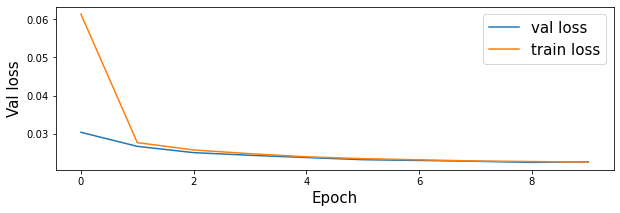

In [216]:
plt.figure(figsize =(10,3))

plt.plot(val_loss, label = "val loss")
plt.plot(train_loss, label = "train loss")
plt.xlabel('Epoch',fontsize=15)
plt.ylabel('Val loss',fontsize=15)

plt.legend(fontsize=15)


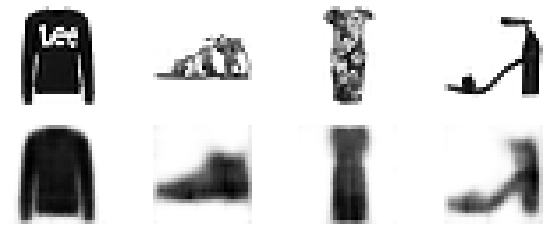

In [217]:
fig, axs = plt.subplots(2, 4, figsize=(10,4))

for i,j in enumerate([1,11,100,1200]):
    x = test_dataset[j][0]
    x = x.reshape([1,1,28,28])
    y = dec(enc(x)).detach()
    axs[0,i].imshow(-x[0][0], cmap='gist_gray')
    axs[1,i].imshow(-y[0][0], cmap='gist_gray')
    
for a in axs.flatten():
    a.set_xticks([])
    a.set_yticks([])
    a.axis('off')
    
plt.savefig("img/original_reconstr.png", dpi = 300)

In [218]:
for x,y in test_dataloader:
    pass

z = dec(enc(x))

print("Test loss: ", nn.MSELoss()(x,z).item())

Test loss:  0.023897195234894753


## FINE TUNING

In [46]:
best_enc = enc

In [47]:
class Net(nn.Module):
    def __init__(self, params):#Ni, Nh1, Nh2, Nh3, No):
        super().__init__()
        #print('Network initialized')
        self.net = nn.Sequential(
            nn.Linear(in_features=4,out_features=params['Nh1']), 
            nn.ReLU(True), 
            nn.Linear(in_features=params['Nh1'], out_features=params['Nh2']),
            nn.ReLU(True), 
            nn.Linear(in_features=params['Nh2'], out_features=10),
            nn.LogSoftmax()
        )
        
        self.params = params

    # Forward step defines how the LightningModule behaves during inference/prediction.
    def forward(self, x):
        return self.net(x)

In [48]:
def train_nn(epochs, enc, net, train_dataloader, val_dataloader, loss_fn, optimizer):
        pbar = tqdm(range(epochs),desc = 'Train loss: ',leave=False)
        Train_loss = []
        Val_loss = []
        for e in pbar:
            train_loss = []
            for x,y in train_dataloader:
                
                #encoder
                x = enc(x)
                
                #forward
                out = net(x)
                
                #loss
                loss = loss_fn(out,y)
                
                #backprop
                net.zero_grad()
                loss.backward()
                
                #optimizer
                optimizer.step()
                
                train_loss.append(loss.detach())
            
            Train_loss.append(np.mean(train_loss))
            pbar.set_description('Train loss: ' + str(Train_loss[-1])[:4])
            
            val_loss = []
            with torch.no_grad():
                for s in val_dataloader:
                    x = s[0]
                    y = s[1]
                    x = enc(x)
                    #forward
                    out = net(x)
                    #loss
                    loss = loss_fn(out,y)

                    val_loss.append(loss.detach())

                Val_loss.append(np.mean(val_loss))
        return Train_loss, Val_loss

In [65]:
train_dataloader = DataLoader(train_dataset, batch_size=200, shuffle=True, num_workers=3)
test_dataloader = DataLoader(test_dataset, batch_size=200, shuffle=False, num_workers=3)

In [70]:
torch.manual_seed(1)

params_nn ={
    'Nh1': 40,
    'Nh2': 60,
    'lr': 1e-3,
    'weight': 1e-3,
    'optimizer': 'Adam'
}

loss_fn = torch.nn.CrossEntropyLoss()
net = Net(params_nn)

optimizer = getattr(optim, params['optimizer'])(net.parameters(), 
                            lr= params['lr'], weight_decay = params["weight"])

epochs = 20
train_loss, val_loss = train_nn(epochs, enc, net, train_dataloader, test_dataloader, loss_fn, optimizer)

Train loss:   0%|          | 0/20 [00:00<?, ?it/s]

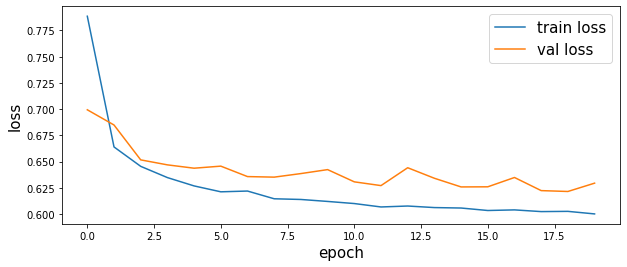

In [108]:
plt.figure(figsize = (10,4))

plt.plot(train_loss, label = "train loss")
plt.plot(val_loss, label = "val loss")
plt.ylabel('loss',fontsize = 15)
plt.xlabel('epoch',fontsize = 15)

plt.legend(fontsize = 15)

plt.savefig("img/fine_tuning_conv.png",dpi=309)

In [73]:
correct = 0
total = 0

with torch.no_grad():
    for data in test_dataloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(enc(images))
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the test images: {100 * correct // total} %')


Accuracy of the network on the test images: 75 %


/home/michele/anaconda3/envs/deep/lib/python3.10/site-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


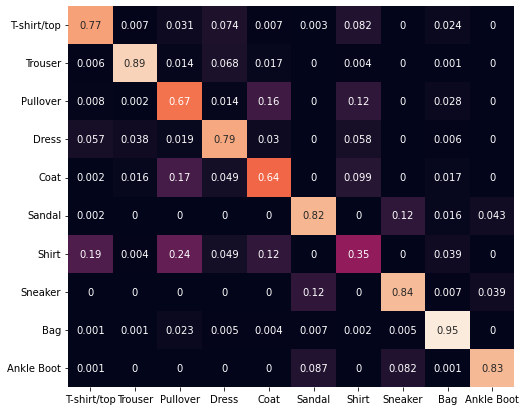

In [74]:
from sklearn.metrics import confusion_matrix
import seaborn as sn

y_pred = []
y_true = []

for inputs, labels in test_dataloader:
        output = net(enc(inputs)) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# constant for classes
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (8,7))
sn.heatmap(df_cm, annot=True, cbar=False)
plt.savefig("img/confusion_matrix.png", dpi =300)

## LATENT SPACE STRUCTURE

In [89]:
labels = ["T-shirt", "Trouser", "Pullover", "Dress", "Coat", "Sandal",
"Shirt", "Sneaker", "Bag", "Ankle boot"]

In [90]:
### Get the encoded representation of the test samples
encoded_samples = []
for sample in tqdm(test_dataset):
    img = sample[0].unsqueeze(0)
    label = sample[1]
    # Encode image
    enc.eval()
    with torch.no_grad():
        encoded_img  = enc(img)
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)
encoded_samples = pd.DataFrame(encoded_samples)
encoded_samples.head()

  0%|          | 0/10000 [00:00<?, ?it/s]

,Enc. Variable 0,Enc. Variable 1,Enc. Variable 2,Enc. Variable 3,label
0,15.953155,-42.002518,-26.983519,-16.718336,9
1,-8.923491,19.320042,-33.314445,65.437653,2
2,-28.037764,56.788029,4.304085,4.320993,1
3,-23.646626,40.833912,14.166115,-6.893320,1
4,-8.354710,9.946445,-6.246733,41.203026,6


In [91]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
encoded_samples_reduced_PCA = pca.fit_transform(encoded_samples)
encoded_samples_reduced_PCA

array([[ 59.34093571, -18.01303791],
       [-20.83829384,  48.2792775 ],
       [-50.12704386, -27.26967142],
       ...,
       [ -7.58352706, -25.65608253],
       [-46.23619066, -54.37596978],
       [ 36.02163526, -12.6228852 ]])

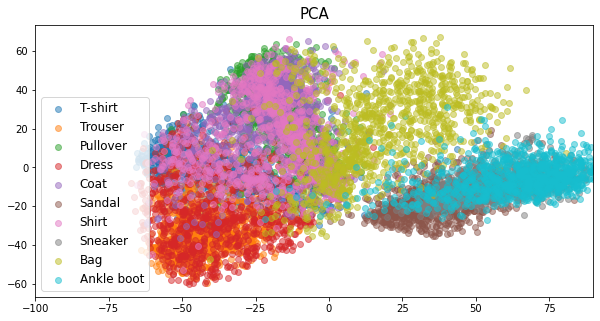

In [103]:
plt.figure(figsize=(10,5))


X = encoded_samples_reduced_PCA[:,0]
Y = encoded_samples_reduced_PCA[:,1]
L = encoded_samples.label.to_numpy()
for i in range(10):
    plt.scatter(X[L == i], Y[L==i], label = labels[i], alpha = 0.5)
    
plt.xlim(-100,90)
    
plt.title("PCA", fontsize=15)
plt.legend(loc = 3,fontsize =12)

plt.savefig("img/PCA.png", dpi = 300)

/home/michele/anaconda3/envs/deep/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/michele/anaconda3/envs/deep/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


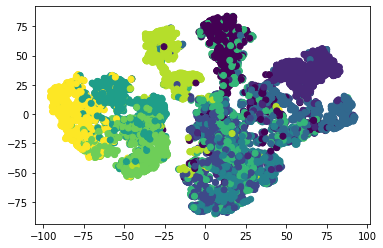

In [93]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
encoded_samples_reduced_TSNE = tsne.fit_transform(encoded_samples)
plt.scatter(encoded_samples_reduced_TSNE[:,0], encoded_samples_reduced_TSNE[:,1], 
            c=encoded_samples.label.to_numpy(), label=encoded_samples.label.to_numpy())


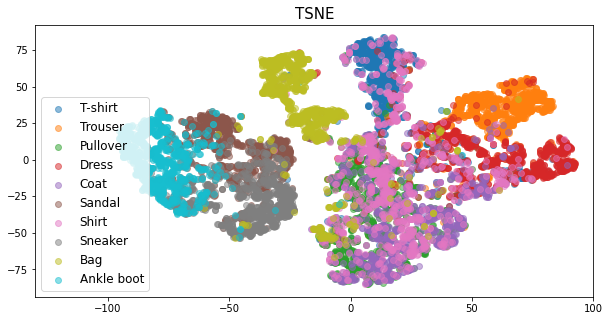

In [102]:
plt.figure(figsize=(10,5))


X = encoded_samples_reduced_TSNE[:,0]
Y = encoded_samples_reduced_TSNE[:,1]
L = encoded_samples.label.to_numpy()
for i in range(10):
    plt.scatter(X[L == i], Y[L==i], label = labels[i], alpha = 0.5)
    
plt.xlim(-130,100)
    
plt.title("TSNE", fontsize=15)
plt.legend(loc = 3,fontsize =12)
plt.savefig("img/TSNE.png", dpi = 300)

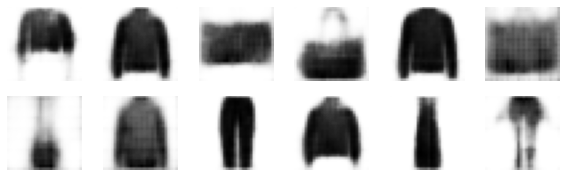

In [64]:
np.random.seed(2010)

fig, axs = plt.subplots(2, 6, figsize=(10,3))

for a in axs.flatten():
    e0 = np.random.choice(encoded_samples['Enc. Variable 0'])
    e1 = np.random.choice(encoded_samples['Enc. Variable 1'])
    e2 = np.random.choice(encoded_samples['Enc. Variable 2'])
    e3 = np.random.choice(encoded_samples['Enc. Variable 3'])

    # Generate a custom sample
    custom_encoded_sample = [e0, e1, e2, e3]
    encoded_value = torch.tensor(custom_encoded_sample).float().unsqueeze(0)

    # Decode sample
    dec.eval()
    with torch.no_grad():
        generated_img  = dec(encoded_value)

    a.imshow(-generated_img.squeeze().cpu().numpy(), cmap='gist_gray')
    a.set_xticks([])
    a.set_yticks([])
    a.axis('off')

    
#plt.title("Generated images", fontsize=15)
plt.savefig("img/gen_imgs.png", dpi = 300)

## VARIATIONAL (CONVOLUTIONAL) AUTOENCODER

In [172]:
class VEncoder(nn.Module):
    
    def __init__(self, params, beta):
        super().__init__()
        
        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            # First convolutional layer
            nn.Conv2d(in_channels=1, out_channels=params['Ch1'], kernel_size=3, 
                      stride=2, padding=1), 
            nn.ReLU(True),
            # Second convolutional layer
            nn.Conv2d(in_channels=params['Ch1'], out_channels=params['Ch2'], kernel_size=3, 
                      stride=2, padding=1),
            nn.ReLU(True),
            # Third convolutional layer
            nn.Conv2d(in_channels=params['Ch2'], out_channels=params['Ch3'], kernel_size=3, 
                      stride=2, padding=0),
            nn.ReLU(True)
        )
        
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)

        ### Linear section
        self.encoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(in_features=9*params['Ch3'], out_features=params['L1'])
            #nn.ReLU(True)
        )
        
        #mu
        self.Lmu = nn.Linear(in_features=params['L1'], out_features=params['LS'])
        #sigma
        self.Lsigma = nn.Linear(in_features=params['L1'], out_features=params['LS'])
        
        self.N = torch.distributions.Normal(0, 1)
        self.kl = 0.
        self.beta = beta
        
    def forward(self, x):
        # Apply convolutions
        x = self.encoder_cnn(x)
        # Flatten
        x = self.flatten(x)
        # # Apply linear layers
        x = self.encoder_lin(x)
        
        mu = self.Lmu(x)
        sigma = torch.exp(self.Lsigma(x))
        
        z = mu + sigma*self.N.sample(mu.shape)
        
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum() * self.beta
        
        return z

In [173]:
### Training function
def train_epoch(encoder, decoder, dataloader, loss_fn, optimizer):
    # Set train mode for both the encoder and the decoder
    encoder.train()
    decoder.train()
    out = []
    for image_batch, _ in dataloader:
        # Encode data
        encoded_data = encoder(image_batch)
        # Decode data
        decoded_data = decoder(encoded_data)
        # Evaluate loss
        loss = loss_fn(decoded_data, image_batch) + encoder.kl
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        out.append(loss.detach())
    return np.mean(out)
        
        
### Testing function
def test_epoch(encoder, decoder, dataloader, loss_fn):
    # Set evaluation mode for encoder and decoder
    encoder.eval()
    decoder.eval()
    with torch.no_grad():
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        for image_batch, _ in dataloader:
            # Encode data
            encoded_data = encoder(image_batch)
            # Decode data
            decoded_data = decoder(encoded_data)
            # Append the network output and the original image to the lists
            conc_out.append(decoded_data)
            conc_label.append(image_batch)
        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_label) + encoder.kl
    return val_loss.data

In [174]:
def train(num_epochs, encoder, decoder, train_dataloader, test_dataloader, loss_fn, optimizer):
    ### Training cycle
    Val_loss = []
    Train_loss = []
    pbar = tqdm(range(num_epochs),desc = 'Val loss: ',leave=False)
    for epoch in pbar:
        ### Training (use the training function)
        train_loss = train_epoch(
            encoder=encoder, 
            decoder=decoder, 
            dataloader=train_dataloader, 
            loss_fn=loss_fn, 
            optimizer=optimizer)
        ### Validation  (use the testing function)
        val_loss = test_epoch(
            encoder=encoder, 
            decoder=decoder, 
            dataloader=test_dataloader, 
            loss_fn=loss_fn)
        Val_loss.append(val_loss)
        Train_loss.append(train_loss)
        pbar.set_description('Val loss: ' + str(val_loss.item())[:4])
        
    return Train_loss,Val_loss

### TRAINING

In [191]:
train_dataloader = DataLoader(train_dataset, batch_size=2000, shuffle=True, num_workers=3)
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False, num_workers=3)

In [192]:
torch.manual_seed(10)

params = {'Ch1': 8, 'Ch2': 17, 'Ch3': 32, 'L1': 69, 'LS': 4, 
          'lr': 0.003082367898008725, 'weight': 0.00012445297763786668, 'optimizer': 'Adam'}


loss_fn = torch.nn.MSELoss(reduction='sum')
enc = VEncoder(params,1)
dec = Decoder(params)

params_to_optimize = [
    {'params': enc.parameters()},
    {'params': dec.parameters()}
]

optimizer = getattr(optim, params['optimizer'])(params_to_optimize, 
                            lr= params['lr'], weight_decay = params["weight"])

epochs = 20
val_loss, train_loss = train(epochs, enc, dec, train_dataloader, test_dataloader, loss_fn, optimizer)

Val loss:   0%|          | 0/20 [00:00<?, ?it/s]

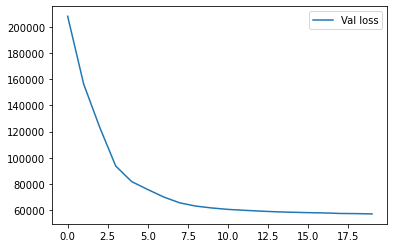

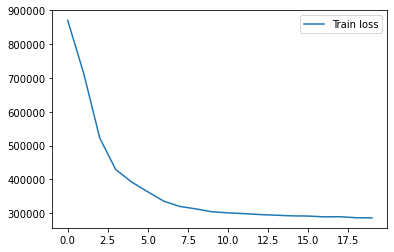

In [193]:
plt.plot(val_loss, label="Val loss")
plt.legend()
plt.figure()
plt.plot(train_loss, label = "Train loss")
plt.legend()

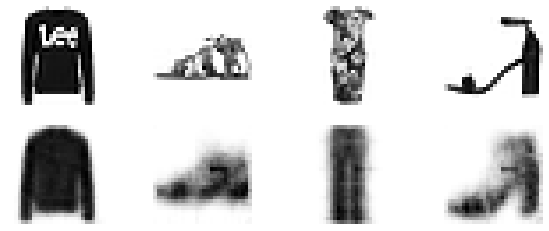

In [194]:
fig, axs = plt.subplots(2, 4, figsize=(10,4))

for i,j in enumerate([1,11,100,1200]):
    x = test_dataset[j][0]
    x = x.reshape([1,1,28,28])
    y = dec(enc(x)).detach()
    axs[0,i].imshow(-x[0][0], cmap='gist_gray')
    axs[1,i].imshow(-y[0][0], cmap='gist_gray')
    
for a in axs.flatten():
    a.set_xticks([])
    a.set_yticks([])
    a.axis('off')
    
plt.savefig("img/original_reconstr_VAE.png", dpi = 300)

### TEST LOSS

In [204]:
for x,y in test_dataloader:
    pass

z = dec(enc(x))

print("Test loss: ", nn.MSELoss()(x,z).item())

Test loss:  0.02702663093805313
